In [1]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import urllib.parse
from tensorflow.keras.metrics import Precision, Recall
from keras.layers import Input, Embedding, Dense, Dropout, Flatten, Conv1D, MaxPool1D, Add, Reshape, BatchNormalization, Concatenate, GlobalMaxPooling1D
from keras import optimizers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import models  
import seaborn as sns

In [2]:
df = pd.read_csv('csic_database.csv')
df = df.rename(columns={'Unnamed: 0':'Target'})

df['Target'] = df['Target'].apply(lambda x:0 if str(x) == 'Normal' else 1)
df = df.drop('classification', axis=1)
#df.head()
#columns_names = df.columns.tolist()
#df1 = df.loc[[df.select_dtypes(object).apply(lambda x: x.str.len()).max(axis=1).idxmax()]]
#l = [' '.join(val) for val in df1.astype(str).values.tolist()] //1232
#print(len(l[0]))
#d = 128
df_y = df['Target']
df_x = df['URL'].str[:-8]
#print(df_y)
#print(df_x)

In [3]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 1 - train_ratio, random_state = 42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 


#print(X_train, X_val, X_test)
def create_label(labels):
  class_list = [x for x in labels]
  classes = np.array(class_list)
  return classes

train_classes = create_label(y_train)
val_classes = create_label(y_val)
test_classes = create_label(y_test)


In [4]:
def url_decode(encoded_URL):
  return urllib.parse.unquote(encoded_URL)

def load_data(urls, max_length=1000):
    urls = [s.lower() for s in urls]
    url_list = []
    for url in urls:    
        decoded_url = url_decode(url)  
        encoded_url = [ord(x) for x in str(decoded_url).strip()]
        encoded_url = encoded_url[:max_length]
        url_len = len(encoded_url)
        if url_len < max_length:
            encoded_url += ([0] * (max_length - url_len))
        url_list.append((encoded_url))
    url_list = np.array(url_list)
    return url_list
    
test_data = pd.concat([X_test, y_test], axis=1)
test_data = pd.DataFrame(test_data)
test_data.to_csv('test_data.csv', index=False)

train_data = load_data(X_train)
val_data = load_data(X_val)
test_data = load_data(X_test)

In [35]:
def create_model(input_max_size, embedding_size, kernel_sizes, dropout):

  inputs = Input(shape=(input_max_size,))

  x = Embedding(0xffff, embedding_size)(inputs)
  x = Reshape((input_max_size, embedding_size))(x)

  convolution_output = []

  for kernel_size in kernel_sizes:
    conv1 = Conv1D(64, kernel_size, activation='relu', padding='same', strides=1)(x)
    pool1 = MaxPool1D(pool_size=kernel_size, padding='same', strides=1)(conv1)
    conv2 = Conv1D(64, kernel_size, activation='relu', padding='same', strides=1)(pool1)
    pool2 = GlobalMaxPooling1D()(conv2)
    convolution_output.append(pool2)

  x = Concatenate()(convolution_output)

  x = Reshape((256, ))(x)

  x = Dense(64, activation='relu')(x)

  x = BatchNormalization()(x)

  x = Dropout(dropout)(x)

  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=inputs, outputs=predictions)

  return model

In [36]:
# config
learning_rate = 0.001
epochs = 50

input_max_size = 1000
embedding_size = 128
kernel_sizes = [4,5,6,7]
dropout = 0.5

loss = 'binary_crossentropy'
optimizer = 'adam'

batch_size = 128

model_filepath = 'model'

start = learning_rate
stop = learning_rate * 0.01
learning_rates = np.linspace(start, stop, epochs)

model = create_model(input_max_size, embedding_size, kernel_sizes, dropout)
optimizer = optimizers.Adam(lr=learning_rate)
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['binary_accuracy', Precision(), Recall()])    

history = model.fit(train_data, train_classes,
              epochs=epochs,
              batch_size=batch_size,
              verbose=2,
              validation_data=(val_data, val_classes)
              )

model.save(model_filepath + '.h5')
hist_df = pd.DataFrame(history.history) 
 


Epoch 1/50


C:\Users\anton\anaconda3\envs\keras\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


358/358 - 253s - loss: 0.3171 - binary_accuracy: 0.8163 - precision_7: 0.7693 - recall_7: 0.7872 - val_loss: 0.2878 - val_binary_accuracy: 0.8172 - val_precision_7: 0.9971 - val_recall_7: 0.5563 - 253s/epoch - 706ms/step
Epoch 2/50
358/358 - 247s - loss: 0.2503 - binary_accuracy: 0.8498 - precision_7: 0.8116 - recall_7: 0.8245 - val_loss: 0.4493 - val_binary_accuracy: 0.8203 - val_precision_7: 0.9991 - val_recall_7: 0.5626 - 247s/epoch - 691ms/step
Epoch 3/50
358/358 - 249s - loss: 0.2419 - binary_accuracy: 0.8530 - precision_7: 0.8132 - recall_7: 0.8319 - val_loss: 0.2309 - val_binary_accuracy: 0.8612 - val_precision_7: 0.7539 - val_recall_7: 0.9827 - 249s/epoch - 697ms/step
Epoch 4/50
358/358 - 253s - loss: 0.2345 - binary_accuracy: 0.8561 - precision_7: 0.8144 - recall_7: 0.8396 - val_loss: 0.3198 - val_binary_accuracy: 0.8533 - val_precision_7: 0.7378 - val_recall_7: 0.9965 - 253s/epoch - 706ms/step
Epoch 5/50
358/358 - 249s - loss: 0.2313 - binary_accuracy: 0.8556 - precision_7: 0

In [22]:
model_filepath = 'model'
model = models.load_model(model_filepath+'.h5')
history = pd.read_csv('history.csv')

191/191 - 9s - loss: 0.2321 - binary_accuracy: 0.8626 - precision_7: 0.7575 - recall_7: 0.9895 - 9s/epoch - 46ms/step
Функция потерь на тестовом наборе:  0.23206032812595367
Точность на тестовом наборе:  0.8626166582107544
Precision на тестовом наборе:  0.7574671506881714
Recall на тестовом наборе:  0.9894654750823975


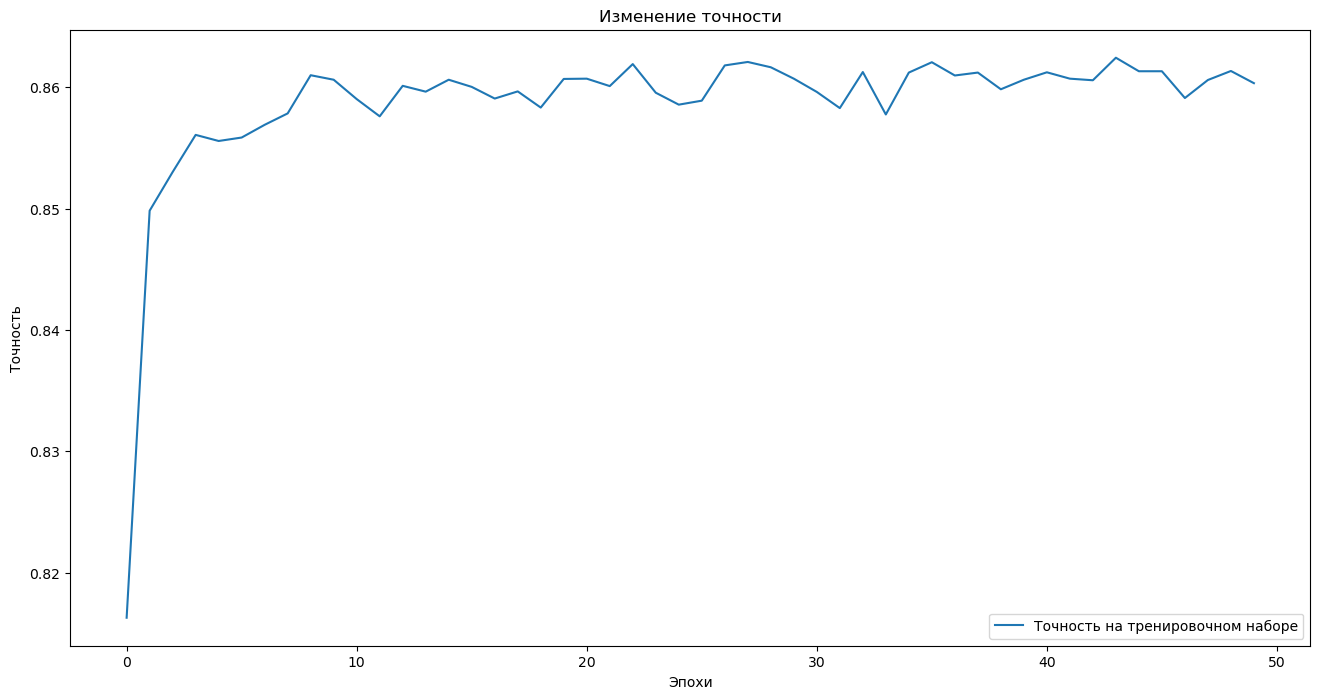

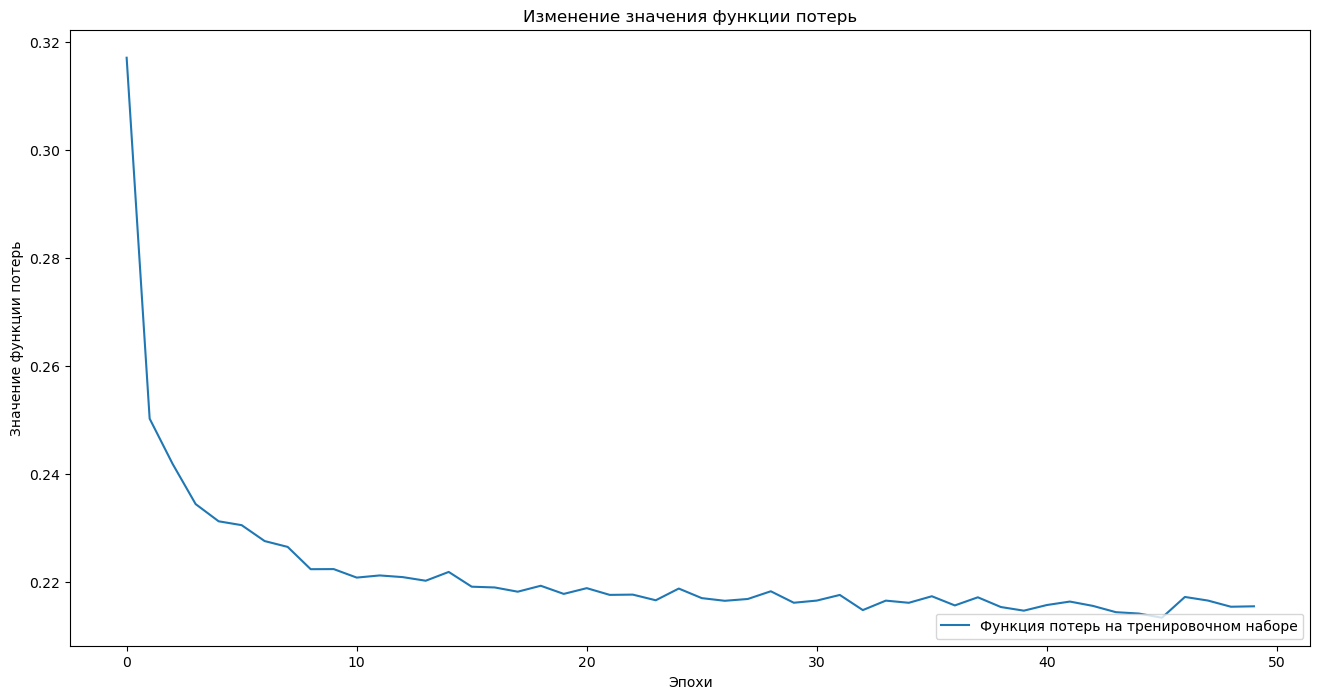

In [23]:
score = model.evaluate(test_data, test_classes, verbose=2)

print("Функция потерь на тестовом наборе: ", score[0])
print("Точность на тестовом наборе: ", score[1])
print("Precision на тестовом наборе: ", score[2])
print("Recall на тестовом наборе: ", score[3])

plt.figure(figsize=(16, 8))
plt.plot(history.iloc[:, [0]], history['binary_accuracy'], label='Точность на тренировочном наборе')
plt.title('Изменение точности')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(history.iloc[:, [0]], history["loss"], label='Функция потерь на тренировочном наборе')
plt.title('Изменение значения функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Значение функции потерь')
plt.legend(loc='lower right')
plt.show()


In [55]:
y_predictions = model.predict(test_data)
y_predictions = y_predictions.ravel().tolist()

191/191 [==============================] - 8s 44ms/step


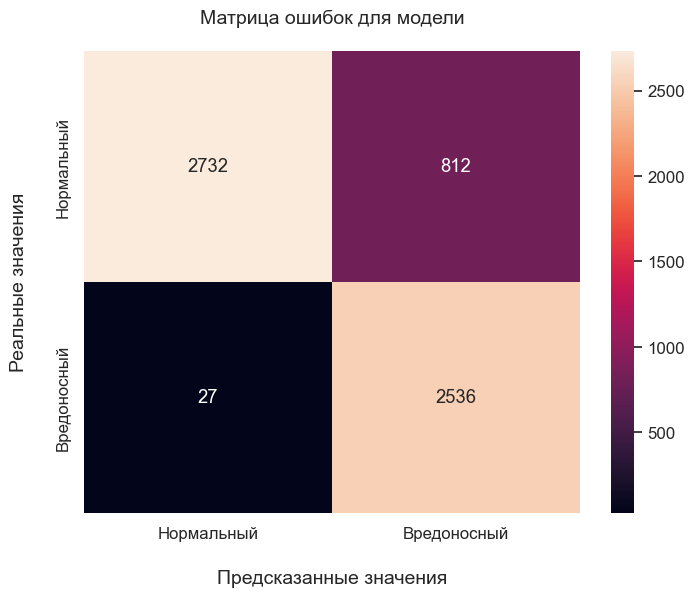

In [56]:

correction = list(map(lambda x:1 if x >= 0.5 else 0, y_predictions))
conf_matrix = confusion_matrix(test_classes, correction)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )
ax.set_xlabel("Предсказанные значения", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Нормальный', 'Вредоносный'])
 

ax.set_ylabel("Реальные значения", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Нормальный', 'Вредоносный'])
 

ax.set_title("Матрица ошибок для модели", fontsize=14, pad=20)
 
plt.show()

In [10]:
def preprocess(url):
    # url decode
    URL_decoded_url = urllib.parse.unquote(url)
    URL_decoded_url = [s.lower() for s in URL_decoded_url]
    # unicode encode
    UNICODE_encoded_url = [ord(x) for x in str(URL_decoded_url).strip()]
    UNICODE_encoded_url = UNICODE_encoded_url[:1000]
    # zero padding
    if len(UNICODE_encoded_url) <= 1000:
        UNICODE_encoded_url += ([0] * (1000 - len(UNICODE_encoded_url)))
    # convert to numpy array
    model_input_url = np.array([UNICODE_encoded_url])
    return model_input_url

model_filepath = 'model'
model = models.load_model(model_filepath+'.h5')
#req = preprocess(url)
y_predictions = model.predict(test_data)
y_predictions = y_predictions.ravel().tolist()
correction = list(map(lambda x:1 if x >= 0.5 else 0, y_predictions))
conf_matrix = confusion_matrix(test_classes, correction)

191/191 [==============================] - 11s 55ms/step


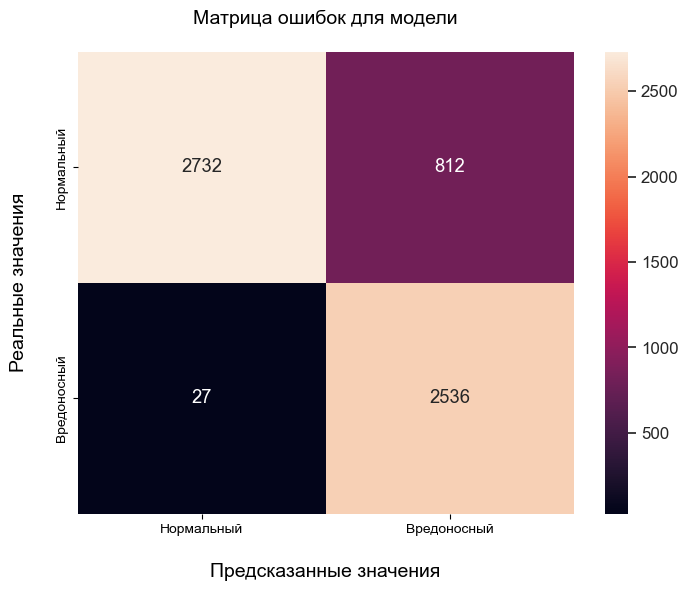

In [11]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', )
ax.set_xlabel("Предсказанные значения", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Нормальный', 'Вредоносный'])
 

ax.set_ylabel("Реальные значения", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Нормальный', 'Вредоносный'])
 

ax.set_title("Матрица ошибок для модели", fontsize=14, pad=20)
 
plt.show()

In [6]:
from sklearn.metrics import roc_auc_score
model = models.load_model('model.h5')
y_predictions = model.predict(test_data)
roc_auc = roc_auc_score(y_test, y_predictions)
print(f"ROC AUC: {roc_auc}")

191/191 [==============================] - 9s 46ms/step
ROC AUC: 0.9560144185927715
